# **Football Player Movment Tracker ⚽️**
---

The project focuses on tracking the players movment using deep sort and usign kaggle dataset contaning imgaes of football match.

---

# **Installing Dependencies 📚**


In [1]:
!pip install ultralytics opencv-python torch torchvision torchaudio scipy scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
!pip install deep-sort-realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 52.9 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import shutil
import yaml
from deep_sort_realtime.deepsort_tracker import DeepSort
import gdown
import seaborn as sns
import os
import json
from pycocotools.coco import COCO
from google.colab import files
import albumentations as A
from albumentations.pytorch import ToTensorV2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Loading data 🗂️**

---



In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahadadel","key":"2df9bffb703a495078df78ade6084be8"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ihelon/football-player-segmentation

Dataset URL: https://www.kaggle.com/datasets/ihelon/football-player-segmentation
License(s): CC0-1.0


In [7]:
!unzip football-player-segmentation.zip

Archive:  football-player-segmentation.zip
  inflating: annotations/instances_default.json  
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/101.jpg          
  inflating: images/102.jpg          
  inflating: images/103.jpg          
  inflating: images/104.jpg          
  inflating: images/106.jpg          
  inflating: images/107.jpg          
  inflating: images/108.jpg          
  inflating: images/109.jpg          
  inflating: images/11.jpg           
  inflating: images/110.jpg          
  inflating: images/111.jpg          
  inflating: images/112.jpg          
  inflating: images/113.jpg          
  inflating: images/114.jpg          
  inflating: images/115.jpg          
  inflating: images/116.jpg          
  inflating: images/117.jpg          
  inflating: images/118.jpg          
  inflating: images/119.jpg          
  inflating: images/12.jpg       

In [8]:
annotations_path = "/content/annotations/instances_default.json"
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [9]:
output_dir = "/content/labels"

In [10]:
os.makedirs(output_dir, exist_ok=True)

In [11]:
category_mapping = {cat["id"]: i for i, cat in enumerate(coco.loadCats(coco.getCatIds()))}

**Changing the format to a format that YOLO allow.**

In [12]:
for image in coco.loadImgs(coco.getImgIds()):
  img_id, img_width, img_height, file_name = image['id'], image['width'], image['height'], image['file_name']
  label_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}.txt")
  annotations = [ann for ann in coco.loadAnns(coco.getAnnIds(imgIds=img_id))]

  with open(label_path, "w") as label_file:
        for ann in annotations:
            x_min, y_min, width, height = ann["bbox"]
            x_center = (x_min + width / 2) / img_width
            y_center = (y_min + height / 2) / img_height
            width /= img_width
            height /= img_height
            class_id = category_mapping[ann["category_id"]]
            label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [13]:
yaml_data = {
    'train': '/content/data/images/train',
    'val': '/content/data/images/val',
    'nc': len(category_mapping),
    'names': [category["name"] for category in coco.loadCats(coco.getCatIds())]
}

In [14]:
with open("/content/data.yaml", "w") as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False)

print("data.yaml created successfully.")

data.yaml created successfully.


# **EDA 📊**

---



In [15]:
images_dir =  "/content/images"

**1. Number of images amd annotations**

---

In [16]:
img_ids = coco.getImgIds()

In [17]:
image_files = [coco.loadImgs(img_id)[0]['file_name'] for img_id in img_ids]

In [18]:
print(f"Total images: {len(image_files)}")
print(f"Total annotations:{len(coco.anns)}")

Total images: 512
Total annotations:7686


**2. Visualize sample of images**

---

In [19]:
def sample_img(dir, num = 5):
  image_files = [os.path.join(dir, x) for x in os.listdir(dir) if x.endswith(".jpg")][:num]
  fig, axes = plt.subplots(1, num, figsize=(15,15))
  for i, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis("off")
  plt.show()

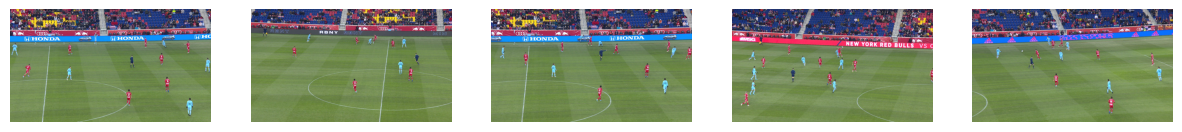

In [20]:
sample_img(images_dir)

**3. Class distribution**

---

In the projet we only focus on the players so this will clarify that we only look for person not ball or any other object.

In [21]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
category_counts = {cat['name']: 0 for cat in categories}

In [22]:
for ann in coco.anns.values():
  cat_id = ann['category_id']
  cat_name = coco.loadCats(cat_id)[0]['name']
  category_counts[cat_name] +=1

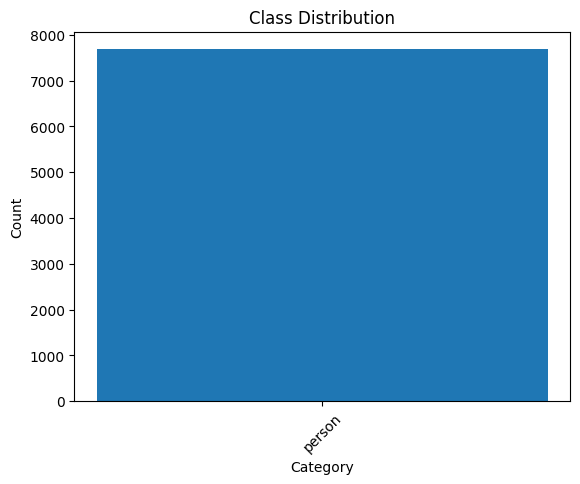

In [23]:
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

**4. Visualize the masks**

---

In [24]:
def plot_segmentation_masks(image_id):
  info = coco.loadImgs(image_id)[0]
  img_path = os.path.join(images_dir, info['file_name'])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ann_ids = coco.getAnnIds(imgIds=image_id)
  anns = coco.loadAnns(ann_ids)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(img)
  for ann in anns:
    mask = coco.annToMask(ann)
    plt.imshow(mask, alpha=0.5, cmap='jet')
  plt.title('Segmentation Masks')
  plt.axis('off')
  plt.show()

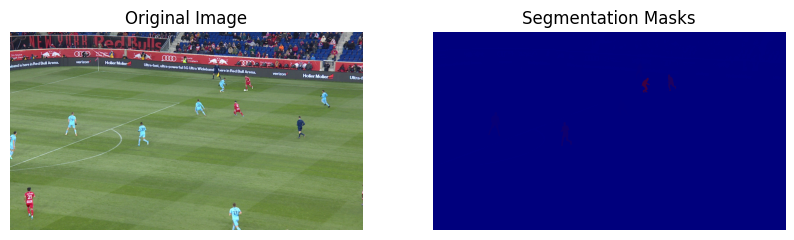

In [25]:
img_sample = img_ids[55]
plot_segmentation_masks(img_sample)

# **Preprocessing 👩‍💻**

---



**1. Augment**

----

In augmention we did not add shift or flip functions because when we did the training was not efficent.

In [26]:
def transform_img(input_dir, save_dir, img_size= 640):
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)

  transform = A.Compose([
    A.Resize(640, 640),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.RandomBrightnessContrast(p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.5),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.GaussianBlur(p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ToTensorV2()
])

  for img_name in os.listdir(input_dir):
    if img_name.endswith(".jpg"):
      img_path = os.path.join(input_dir, img_name)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      augmented = transform(image = img)
      output_img = augmented['image']
      output_img = output_img.permute(1, 2, 0).numpy()
      output_img = (output_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255  # Denormalize
      output_img = output_img.astype(np.uint8)
      save_img_path = os.path.join(save_dir, img_name)
      cv2.imwrite(save_img_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

In [27]:
transform_img("/content/images", "/content/Preprocessed_images")

/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/functional.py:1279: RuntimeWarning: invalid value encountered in power
  return np.power(img, gamma)
<ipython-input-26-7af54b51fad8>:26: RuntimeWarning: invalid value encountered in cast
  output_img = output_img.astype(np.uint8)


In [28]:
augmented_img = "/content/Preprocessed_images"

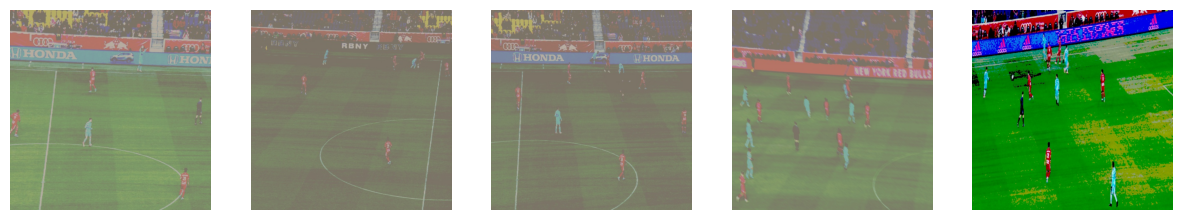

In [29]:
sample_img(augmented_img)

In [30]:
def rename(dir):
  for filename in os.listdir(dir):
    if filename.endswith('.jpg'):
      new_filename = "Aug_" + filename
      source_path = os.path.join(dir, filename)
      destination_path = os.path.join(dir, new_filename)
      os.rename(source_path, destination_path)

In [31]:
rename(augmented_img)

**3. Combine images**

In [32]:
def combine_images(org_dir, prepro_img, combined_img):
  if not os.path.exists(combined_img):
    os.makedirs(combined_img)

  for img in os.listdir(org_dir):
    if img.endswith(".jpg"):
      src_path = os.path.join(org_dir, img)
      dst_path = os.path.join(combined_img, img)
      shutil.copy(src_path, dst_path)

  for img in os.listdir(prepro_img):
    if img.endswith(".jpg"):
      src_path = os.path.join(prepro_img, img)
      dst_path = os.path.join(combined_img, f"{img}")
      shutil.copy(src_path, dst_path)

In [33]:
combine_images(images_dir, augmented_img, "/content/combined_images")

In [34]:
def combine_annotations(org_dir, prepro_dir, combined_dir):
  if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

  for ann in os.listdir(org_dir):
    if ann.endswith(".txt"):
      src_path = os.path.join(org_dir, ann)
      dst_path = os.path.join(combined_dir, ann)
      shutil.copy(src_path, dst_path)

  for ann in os.listdir(prepro_dir):
    if ann.endswith(".txt"):
      src_path = os.path.join(prepro_dir, ann)
      dst_path = os.path.join(combined_dir, f"Aug_{ann}")
      shutil.copy(src_path, dst_path)

In [35]:
combine_annotations("/content/labels", "/content/labels", "/content/combined_annotations")

In [36]:
combined_images = os.listdir("/content/combined_images")
combined_annotations = os.listdir("/content/combined_annotations")

In [37]:
print(f"Number of combined images: {len(combined_images)}")
print(f"Number of combined annotations: {len(combined_annotations)}")

Number of combined images: 1024
Number of combined annotations: 1024


In [38]:
# Create the 'data' directory
!mkdir data

# Move the directories
!mv /content/combined_annotations data/
!mv /content/combined_images data/
!mv /content/data.yaml data/


In [39]:
shutil.move("/content/data/combined_annotations", "/content/data/labels")

'/content/data/labels'

**YOLO allows for a certian dir structure.**

In [40]:
# Define paths
base_dir = "/content/data"
image_dir = os.path.join(base_dir, "combined_images")
label_dir = os.path.join(base_dir, "labels")

# Define YOLO directories
train_images = os.path.join(base_dir, "images", "train")
val_images = os.path.join(base_dir, "images", "val")
train_labels = os.path.join(base_dir, "labels", "train")
val_labels = os.path.join(base_dir, "labels", "val")

# Create directories if they don't exist
os.makedirs(train_images, exist_ok=True)
os.makedirs(val_images, exist_ok=True)
os.makedirs(train_labels, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

# Get image and label file names
images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
labels = [f.replace(".jpg", ".txt") for f in images]

# Split data into training and validation sets
train_images_names, val_images_names, train_labels_names, val_labels_names = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Move training data
for image_name in train_images_names:
    shutil.move(os.path.join(image_dir, image_name), os.path.join(train_images, image_name))
for label_name in train_labels_names:
    shutil.move(os.path.join(label_dir, label_name), os.path.join(train_labels, label_name))


# Move validation data
for image_name in val_images_names:
    shutil.move(os.path.join(image_dir, image_name), os.path.join(val_images, image_name))
for label_name in val_labels_names:
    shutil.move(os.path.join(label_dir, label_name), os.path.join(val_labels, label_name))

print("✅ Files moved to the correct structure.")


✅ Files moved to the correct structure.


In [41]:
def plot_image_with_box(image_path, annotations_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(annotations_path, 'r') as f:
        lines = f.readlines()

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_min = int((x_center - width / 2) * img.shape[1])
        y_min = int((y_center - height / 2) * img.shape[0])
        x_max = int((x_center + width / 2) * img.shape[1])
        y_max = int((y_center + height / 2) * img.shape[0])

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    plt.show()

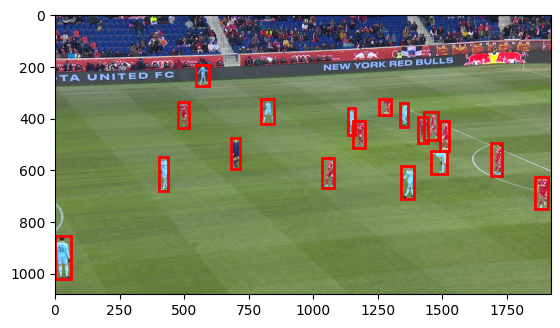

In [42]:
image_file = "/content/data/images/train/1.jpg" # example image
annotation_file = "/content/data/labels/train/1.txt" # corresponding annotation
plot_image_with_box(image_file, annotation_file)

# **Fine Tuning YOLOV8**

---



In [43]:
dataset_yaml = "/content/data/data.yaml"

In [44]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 237MB/s]


In [45]:
model.train(data=dataset_yaml, epochs=100, imgsz=640, batch=32, device='cuda', plots=True)

Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

100%|██████████| 755k/755k [00:00<00:00, 23.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 87.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2614.5±2015.0 MB/s, size: 441.0 KB)


train: Scanning /content/data/labels/train... 819 images, 0 backgrounds, 0 corrupt: 100%|██████████| 819/819 [00:00<00:00, 2324.28it/s]

train: /content/data/images/train/209.jpg: 7 duplicate labels removed
train: /content/data/images/train/Aug_209.jpg: 7 duplicate labels removed
train: New cache created: /content/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 951.0±909.0 MB/s, size: 311.4 KB)


val: Scanning /content/data/labels/val... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 955.04it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.97G      1.308      1.367       1.04        457        640: 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        205       3125      0.471      0.635      0.356      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.07G      1.161     0.9262     0.9647        450        640: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


                   all        205       3125      0.628      0.652      0.557      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.88G      1.207     0.9216     0.9793        364        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        205       3125      0.778      0.669      0.612      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.07G      1.216     0.8985     0.9686        485        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        205       3125      0.752      0.614       0.66      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.88G      1.179     0.8909     0.9698        468        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all        205       3125      0.726      0.601      0.642      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.91G      1.126     0.8649     0.9542        351        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        205       3125      0.792      0.666      0.684      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.98G      1.093     0.8403     0.9519        409        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        205       3125      0.811      0.589       0.67       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.17G       1.07     0.8329     0.9507        381        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        205       3125      0.827      0.616      0.685      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.98G      1.047     0.8115     0.9378        363        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        205       3125      0.797      0.585      0.657      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       7.1G      1.053     0.8248     0.9488        427        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        205       3125      0.777      0.655      0.671      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.86G      1.023     0.7887     0.9321        465        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        205       3125      0.817       0.67      0.712      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       6.9G      1.023     0.7835     0.9321        454        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all        205       3125      0.808      0.672      0.716      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.06G      1.009     0.8082     0.9376        407        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        205       3125      0.843      0.695      0.722      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.11G     0.9721     0.7528     0.9229        401        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        205       3125      0.882      0.672      0.728      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.95G     0.9714     0.7524     0.9211        565        640: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        205       3125      0.861      0.676      0.721      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.25G     0.9967     0.7721     0.9318        414        640: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        205       3125       0.86      0.676      0.721      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.19G     0.9915     0.7755     0.9301        360        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        205       3125      0.844      0.686      0.713      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.07G     0.9682     0.7267     0.9202        473        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        205       3125      0.814      0.686      0.703      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.86G     0.9352     0.6984     0.9113        382        640: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        205       3125      0.853      0.693      0.731      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.88G     0.9542     0.7232      0.916        365        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        205       3125      0.869      0.671      0.727      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.87G     0.9543      0.736     0.9193        418        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


                   all        205       3125      0.882      0.693      0.739      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.88G     0.9169     0.7057     0.9056        373        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        205       3125      0.799      0.679      0.697      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.11G     0.9287     0.7144     0.9123        474        640: 100%|██████████| 26/26 [00:16<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        205       3125      0.834      0.699      0.706      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.05G     0.9654     0.7658     0.9256        404        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        205       3125      0.917       0.66      0.733       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       6.9G     0.9655     0.7553     0.9264        478        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        205       3125      0.845      0.666      0.716      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.09G     0.9663     0.7353     0.9219        495        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        205       3125      0.849       0.67      0.724      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.1G     0.9246     0.6989     0.9139        424        640: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        205       3125      0.854      0.676      0.726      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.91G     0.8957     0.6818     0.9068        452        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        205       3125      0.884       0.69      0.738      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.86G     0.9214     0.6993     0.9085        444        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        205       3125      0.821      0.701      0.704      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.89G     0.9071     0.6811     0.9111        426        640: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        205       3125      0.861      0.694      0.728      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.86G     0.8953     0.6767      0.904        419        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


                   all        205       3125      0.863      0.687      0.731      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.95G     0.8857     0.6659      0.904        482        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        205       3125      0.871      0.683      0.723      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.05G     0.9124      0.691     0.9083        385        640: 100%|██████████| 26/26 [00:17<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        205       3125      0.901      0.685      0.737      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.15G     0.8972     0.7026     0.9124        407        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        205       3125      0.888      0.686       0.74      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.87G     0.8988     0.6695     0.9054        383        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        205       3125       0.87      0.699      0.733      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.88G     0.8862     0.6666     0.9015        496        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        205       3125      0.866      0.693      0.733      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.97G     0.8995     0.6766     0.9093        479        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        205       3125      0.904      0.681      0.744      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.16G     0.8833     0.6605     0.8987        577        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        205       3125       0.89      0.658      0.726      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.08G     0.8384     0.6327     0.8914        446        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

                   all        205       3125      0.861      0.694       0.72      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       7.1G     0.8744      0.662     0.8975        424        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        205       3125      0.832      0.705       0.73      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.06G     0.8794     0.6541     0.8974        442        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        205       3125      0.859      0.699      0.735        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.07G     0.8659     0.6478      0.893        375        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        205       3125       0.87      0.702      0.736      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.45G     0.8755     0.6726      0.907        344        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        205       3125       0.87      0.695      0.742      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.05G     0.8678      0.668     0.9008        402        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


                   all        205       3125      0.909      0.687      0.746        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.87G     0.8757     0.6641     0.9073        396        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        205       3125      0.916      0.696      0.746      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.09G     0.8541      0.645     0.8945        387        640: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        205       3125      0.865      0.695      0.721      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.92G     0.8548     0.6317     0.8963        577        640: 100%|██████████| 26/26 [00:17<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        205       3125      0.934      0.651      0.732      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.05G     0.8763     0.6684     0.9027        392        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        205       3125      0.882      0.691      0.734      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.87G      0.837     0.6265     0.8929        447        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        205       3125        0.9      0.694      0.743      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.06G     0.8376     0.6309     0.8889        384        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        205       3125      0.916      0.687      0.751      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.05G     0.8446      0.633      0.898        384        640: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        205       3125      0.839      0.702      0.721      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.05G     0.8102     0.5956     0.8842        409        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        205       3125      0.899      0.691      0.743      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.08G     0.8497     0.6476      0.898        435        640: 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


                   all        205       3125      0.917      0.693      0.751      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.35G     0.8521      0.641     0.8997        478        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        205       3125      0.907      0.703      0.754      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.11G     0.8272     0.6116     0.8935        338        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        205       3125      0.876      0.693      0.734      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.11G     0.8537     0.6408     0.8951        449        640: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        205       3125      0.896      0.696      0.747      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.9G     0.8337     0.6228     0.8885        433        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        205       3125      0.896      0.693      0.747      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.9G     0.8503     0.6483     0.8997        465        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        205       3125      0.914      0.705      0.756      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.88G      0.823     0.6131     0.8876        493        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        205       3125      0.932      0.701      0.754      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.89G     0.8544     0.6453     0.8966        408        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        205       3125      0.865      0.685      0.732      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.09G      0.834     0.6096     0.8851        534        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        205       3125      0.935      0.675      0.745      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       7.2G     0.8239     0.6082     0.8854        522        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        205       3125      0.902      0.708       0.75      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.19G      0.836     0.6218     0.8871        505        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        205       3125      0.916      0.704      0.751      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.88G     0.7888      0.584     0.8823        418        640: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        205       3125      0.895       0.69      0.737       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.08G     0.8016     0.5962     0.8827        349        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        205       3125      0.933       0.69       0.75      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.91G     0.8102     0.6159     0.8913        437        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        205       3125      0.882      0.701      0.747       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.21G      0.814     0.6031      0.884        376        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        205       3125      0.932      0.691       0.75      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.11G     0.8187     0.5924     0.8817        355        640: 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        205       3125      0.912      0.707      0.751      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.1G     0.7822     0.5744     0.8751        489        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        205       3125      0.927      0.701      0.759      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       6.9G      0.796     0.5794     0.8802        411        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        205       3125      0.923      0.695      0.753      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       6.9G      0.791     0.5834     0.8834        388        640: 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        205       3125      0.905      0.686      0.739      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.9G     0.8157     0.6076      0.886        499        640: 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        205       3125      0.915      0.706       0.75      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.86G     0.8186     0.6131     0.8857        394        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        205       3125      0.923      0.705      0.757      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.09G     0.7831     0.5704     0.8751        472        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        205       3125      0.921      0.687      0.754      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.95G     0.8052     0.5929     0.8845        437        640: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        205       3125      0.931      0.699      0.758      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.03G     0.7933     0.5831     0.8803        415        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        205       3125      0.932      0.706      0.753      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.07G      0.796     0.5806     0.8756        452        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]

                   all        205       3125      0.932      0.702      0.752      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       7.1G     0.7772     0.5666     0.8743        413        640: 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        205       3125      0.928      0.696      0.755      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.89G     0.7806     0.5718     0.8761        464        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        205       3125      0.904      0.707      0.755      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.17G     0.7938     0.5804     0.8778        429        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        205       3125      0.949      0.698      0.753      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.09G     0.7941     0.5878     0.8827        355        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        205       3125       0.92      0.705      0.755       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.34G     0.7757     0.5555     0.8741        413        640: 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        205       3125      0.954        0.7      0.759      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.09G     0.7546     0.5476     0.8724        443        640: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        205       3125       0.94      0.704      0.758      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.05G     0.7733     0.5573     0.8715        387        640: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        205       3125      0.933      0.707      0.756       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.09G     0.7808     0.5739     0.8755        493        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        205       3125      0.915      0.712      0.762       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.98G     0.7622     0.5504      0.871        394        640: 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        205       3125      0.933      0.705      0.759      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.05G     0.7504     0.5291     0.8683        431        640: 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        205       3125      0.906      0.713      0.753      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.87G     0.7482     0.5354      0.868        507        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        205       3125      0.955      0.698      0.758      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.9G     0.7573     0.5446     0.8716        353        640: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        205       3125      0.948      0.703       0.76      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.92G      0.752     0.5429     0.8724        383        640: 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        205       3125      0.952      0.706      0.763      0.639


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.87G      0.778     0.6009     0.9029        250        640: 100%|██████████| 26/26 [00:21<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        205       3125      0.917      0.708      0.756      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.79G     0.7612     0.5859     0.8983        237        640: 100%|██████████| 26/26 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        205       3125      0.927      0.711      0.762      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.07G     0.7443     0.5685     0.8887        275        640: 100%|██████████| 26/26 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        205       3125       0.93      0.708      0.759      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.86G     0.7462     0.5802     0.8923        246        640: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        205       3125      0.948      0.701      0.762      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.78G      0.751     0.5844     0.8931        249        640: 100%|██████████| 26/26 [00:17<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        205       3125      0.926      0.701      0.756      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.78G     0.7455     0.5772     0.8943        242        640: 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        205       3125      0.934       0.71      0.762      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.78G     0.7477     0.5776     0.8935        259        640: 100%|██████████| 26/26 [00:17<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        205       3125      0.948      0.707      0.762      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       6.7G     0.7386     0.5614     0.8899        257        640: 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        205       3125      0.943      0.708      0.764      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.85G     0.7361      0.571     0.8895        261        640: 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        205       3125      0.942      0.708      0.764      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.87G     0.7459      0.576     0.8938        259        640: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        205       3125       0.95      0.706      0.765      0.641



100 epochs completed in 0.639 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


                   all        205       3125       0.95      0.706      0.765      0.641
Speed: 0.3ms preprocess, 5.2ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6201bc9650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

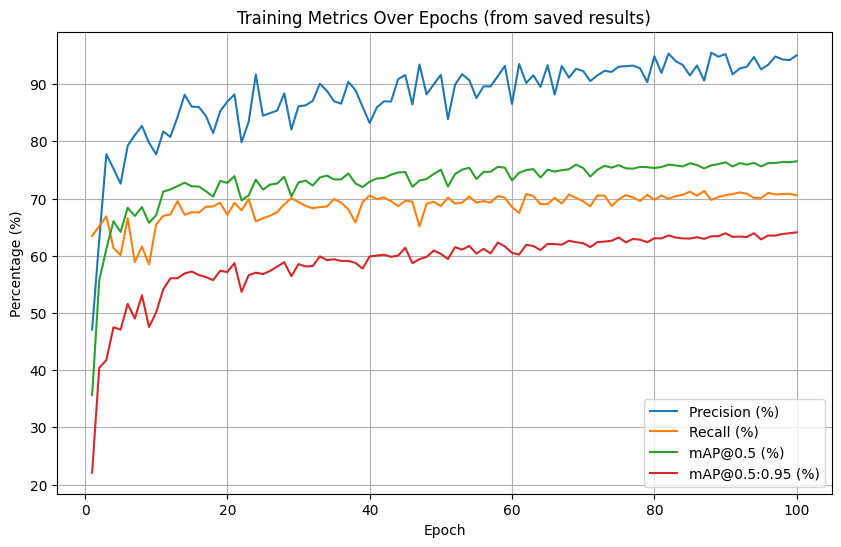

Final Precision: 95.04%
Final Recall: 70.56%
Final mAP@0.5: 76.52%
Final mAP@0.5:0.95: 64.09%


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your results CSV
df = pd.read_csv('/content/runs/detect/train/results.csv')

# Plot using correct column names
epochs = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, df['metrics/precision(B)'] * 100, label='Precision (%)')
plt.plot(epochs, df['metrics/recall(B)'] * 100, label='Recall (%)')
plt.plot(epochs, df['metrics/mAP50(B)'] * 100, label='mAP@0.5 (%)')
plt.plot(epochs, df['metrics/mAP50-95(B)'] * 100, label='mAP@0.5:0.95 (%)')

plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.title('Training Metrics Over Epochs (from saved results)')
plt.legend()
plt.grid(True)
plt.show()

# Get the last row (final epoch results)
final_metrics = df.iloc[-1]

# Extract and print nicely
precision = final_metrics['metrics/precision(B)'] * 100
recall = final_metrics['metrics/recall(B)'] * 100
map_50 = final_metrics['metrics/mAP50(B)'] * 100
map_50_95 = final_metrics['metrics/mAP50-95(B)'] * 100

print(f"Final Precision: {precision:.2f}%")
print(f"Final Recall: {recall:.2f}%")
print(f"Final mAP@0.5: {map_50:.2f}%")
print(f"Final mAP@0.5:0.95: {map_50_95:.2f}%")


In [47]:
metrics = model.val()

Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1959.6±1219.8 MB/s, size: 337.9 KB)


val: Scanning /content/data/labels/val.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        205       3125      0.951      0.706      0.766      0.646
Speed: 2.9ms preprocess, 8.3ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train2


In [48]:
best_model_path = "/content/runs/detect/train/weights/best.pt"
model = YOLO(best_model_path)

# **DeepSort Tracker**

---



In [49]:
deep_sort = DeepSort(max_age=30, n_init=3, nn_budget=400)

In [50]:
output_tracking_results = "/content/tracking_results.txt"

**Velocity Calculation help in the players movment by using the player speed and their postiations.**

In [51]:
def calculate_velocity(player_positions, track_id, frame_idx, velocity_memory=3):
    if track_id not in player_positions or len(player_positions[track_id]) < 2:
        return np.array([0, 0])

    recent_positions = player_positions[track_id][-velocity_memory:]
    if len(recent_positions) < 2:
        return np.array([0, 0])


    times = np.array([pos[0] for pos in recent_positions])
    positions = np.array([(pos[1], pos[2]) for pos in recent_positions])

    if len(times) >= 2:
        dt = times[-1] - times[0]
        if dt > 0:
            velocity = (positions[-1] - positions[0]) / dt
            return velocity
    return np.array([0, 0])

**Predicting a collision by the speed and position.**

Trial

Processing video with proximity threshold 20...

0: 640x384 7 persons, 42.8ms
Speed: 2.5ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 1.9ms preprocess, 10.6ms i

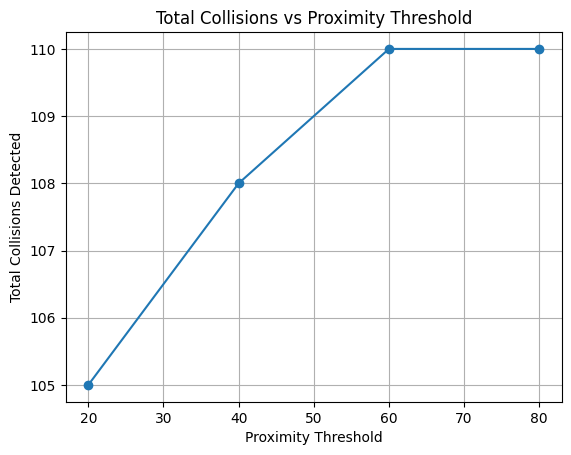

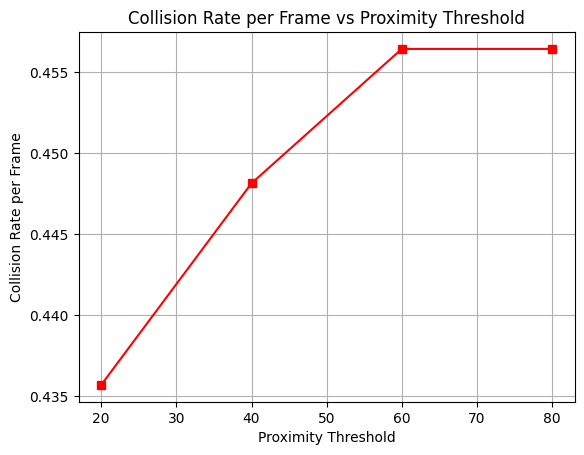

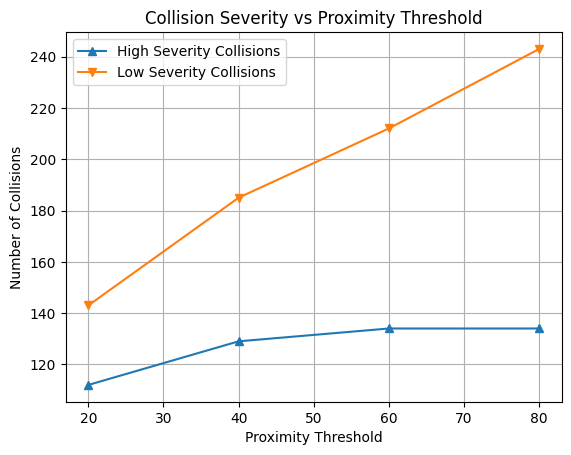

Threshold 20:
  Total Collisions: 105
  Frames: 241
  Collision per Frame: 0.4357
  High Severity: 112
  Low Severity: 143

Threshold 40:
  Total Collisions: 108
  Frames: 241
  Collision per Frame: 0.4481
  High Severity: 129
  Low Severity: 185

Threshold 60:
  Total Collisions: 110
  Frames: 241
  Collision per Frame: 0.4564
  High Severity: 134
  Low Severity: 212

Threshold 80:
  Total Collisions: 110
  Frames: 241
  Collision per Frame: 0.4564
  High Severity: 134
  Low Severity: 243



In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define predict_collision function ---
def predict_collision(pos1, vel1, pos2, vel2, frames_ahead=10, proximity_threshold=60):
    future_positions1 = [pos1 + vel1 * t for t in range(frames_ahead)]
    future_positions2 = [pos2 + vel2 * t for t in range(frames_ahead)]

    min_distance = float('inf')
    for p1, p2 in zip(future_positions1, future_positions2):
        distance = np.linalg.norm(np.array(p1) - np.array(p2))
        min_distance = min(min_distance, distance)

    return min_distance < proximity_threshold

# --- Step 2: Define detect_and_track_players function with velocity calculation ---
def detect_and_track_players(frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=60):
    results = model.predict(source=frame, conf=0.5, save=False, device=0)
    detections = []
    player_velocities = {}
    collision_pairs = []
    collision_ids = set()  # New: to keep track of colliding players

    # Detection step
    for r in results:
        if len(r.boxes) > 0:
            for box in r.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                detections.append([[x1, y1, x2 - x1, y2 - y1], conf, cls])

    # Tracking step
    tracks = deep_sort.update_tracks(detections, frame=frame)
    tracked_players = []

    with open(output_tracking_results, "a") as f:
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = map(int, track.to_ltrb())

            if track_id not in player_positions:
                player_positions[track_id] = []

            center = np.array([(l + r) / 2, (t + b) / 2])
            player_positions[track_id].append((frame_idx, center[0], center[1]))
            tracked_players.append(([l, t, r, b, 1.0], track_id))

            f.write(f"{frame_idx},{track_id},{l},{t},{r-l},{b-t},1,-1,-1,-1\n")

    # Compute velocities
    for track_id, positions in player_positions.items():
        if len(positions) >= 2:
            (frame_prev, x_prev, y_prev) = positions[-2]
            (frame_now, x_now, y_now) = positions[-1]

            dt = frame_now - frame_prev
            if dt > 0:
                velocity = np.array([(x_now - x_prev) / dt, (y_now - y_prev) / dt])
            else:
                velocity = np.array([0, 0])
        else:
            velocity = np.array([0, 0])

        player_velocities[track_id] = velocity

    # Collision detection
    severity_counts = {"high": 0, "low": 0}

    for i in range(len(tracked_players)):
        for j in range(i + 1, len(tracked_players)):
            (x1, y1, x2, y2, _), id1 = tracked_players[i]
            (x3, y3, x4, y4, _), id2 = tracked_players[j]

            center1 = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
            center2 = np.array([(x3 + x4) / 2, (y3 + y4) / 2])
            vel1 = player_velocities.get(id1, np.array([0, 0]))
            vel2 = player_velocities.get(id2, np.array([0, 0]))

            intersection_x = max(0, min(x2, x4) - max(x1, x3))
            intersection_y = max(0, min(y2, y4) - max(y1, y3))
            intersection_area = intersection_x * intersection_y
            b1_area = (x2 - x1) * (y2 - y1)
            b2_area = (x4 - x3) * (y4 - y3)
            iou = 0
            if b1_area + b2_area - intersection_area > 0:
                iou = intersection_area / (b1_area + b2_area - intersection_area)

            collision_detected = (iou > 0.5 or predict_collision(center1, vel1, center2, vel2, proximity_threshold))

            if collision_detected:
                rel_velocity = np.linalg.norm(vel1 - vel2)
                severity = "HIGH" if rel_velocity > 8 else "LOW"

                severity_counts["high" if severity == "HIGH" else "low"] += 1
                collision_pairs.append((center1, center2, severity))

                # Mark these IDs as colliding
                collision_ids.add(id1)
                collision_ids.add(id2)

    # --- Draw bounding boxes and velocity arrows ---
    for (bbox, track_id) in tracked_players:
        x1, y1, x2, y2, _ = bbox
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

        # Flashing box color if in collision
        if track_id in collision_ids:
            color = (0, 0, 255)  # RED for players involved in collisions
            thickness = 4
        else:
            color = (0, 255, 0)  # GREEN normal
            thickness = 2

        # Draw bounding box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

        # Draw velocity arrow
        if track_id in player_velocities:
            velocity = player_velocities[track_id]
            speed = np.linalg.norm(velocity)
            if speed > 0.5:
                end_point = center + velocity * 10
                cv2.arrowedLine(frame, tuple(center.astype(int)), tuple(end_point.astype(int)), (255, 0, 0), 2)

    # --- Draw collision connection lines ---
    for center1, center2, severity in collision_pairs:
        color = (0, 0, 255) if severity == "HIGH" else (0, 165, 255)
        cv2.line(frame, tuple(center1.astype(int)), tuple(center2.astype(int)), color, 3)

        # Draw text at midpoint
        mid_point = ((center1 + center2) / 2).astype(int)
        text = f"Collision {severity}"
        cv2.putText(frame, text, (mid_point[0]-50, mid_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return tracked_players, len(collision_pairs) > 0, severity_counts

# --- Step 3: Process video across thresholds ---
video_path = "Cand22.mp4"  # << replace with your real path
thresholds = [20, 40, 60, 80]

results_per_threshold = {t: {"total_collisions": 0, "high_severity": 0, "low_severity": 0, "frames": 0} for t in thresholds}

for threshold in thresholds:
    print(f"Processing video with proximity threshold {threshold}...")
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    player_positions = {}
    player_speeds = {}
    player_durations = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            print(f"[Warning] Failed to read frame for threshold {threshold} at frame {frame_idx}")
            break

        tracked_players, collision_detected, severity_counts = detect_and_track_players(
            frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=threshold
        )

        if collision_detected:
            results_per_threshold[threshold]["total_collisions"] += 1
            results_per_threshold[threshold]["high_severity"] += severity_counts["high"]
            results_per_threshold[threshold]["low_severity"] += severity_counts["low"]

        results_per_threshold[threshold]["frames"] += 1
        frame_idx += 1

    cap.release()

# --- Step 4: Safely calculate and plot results ---
thresholds_sorted = sorted(results_per_threshold.keys())
total_collisions = [results_per_threshold[t]["total_collisions"] for t in thresholds_sorted]
collision_per_frame = [
    results_per_threshold[t]["total_collisions"] / results_per_threshold[t]["frames"]
    if results_per_threshold[t]["frames"] > 0 else 0
    for t in thresholds_sorted
]
high_severity = [results_per_threshold[t]["high_severity"] for t in thresholds_sorted]
low_severity = [results_per_threshold[t]["low_severity"] for t in thresholds_sorted]

# Plot Total Collisions
plt.figure()
plt.plot(thresholds_sorted, total_collisions, marker='o')
plt.title("Total Collisions vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Total Collisions Detected")
plt.grid(True)
plt.show()

# Plot Collision Rate per Frame
plt.figure()
plt.plot(thresholds_sorted, collision_per_frame, marker='s', color='red')
plt.title("Collision Rate per Frame vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Collision Rate per Frame")
plt.grid(True)
plt.show()

# Plot Severity
plt.figure()
plt.plot(thresholds_sorted, high_severity, marker='^', label="High Severity Collisions")
plt.plot(thresholds_sorted, low_severity, marker='v', label="Low Severity Collisions")
plt.title("Collision Severity vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Number of Collisions")
plt.legend()
plt.grid(True)
plt.show()

# --- Step 5: Print results ---
for threshold, data in results_per_threshold.items():
    print(f"Threshold {threshold}:")
    print(f"  Total Collisions: {data['total_collisions']}")
    print(f"  Frames: {data['frames']}")
    if data['frames'] > 0:
        print(f"  Collision per Frame: {data['total_collisions'] / data['frames']:.4f}")
    else:
        print("  Collision per Frame: N/A (no frames)")
    print(f"  High Severity: {data['high_severity']}")
    print(f"  Low Severity: {data['low_severity']}")
    print()


# **Test the model wit a video.**

---



In [55]:
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# --- Step 6: Process the video for saving ---
output_video_path = "processed_Cand22.mp4"
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

frame_idx = 0
player_positions = {}
player_speeds = {}
player_durations = {}

# For visualizations
speeds_over_time = {}  # {player_id: [(frame, speed)]}
all_positions_x = []
all_positions_y = []

total_high_severity = 0
total_low_severity = 0
total_collisions = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    tracked_players, collision_detected, severity_counts = detect_and_track_players(
        frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=60
    )

    total_collisions += collision_detected
    total_high_severity += severity_counts["high"]
    total_low_severity += severity_counts["low"]

 # Draw player velocities and collect speeds
    for bbox, track_id in tracked_players:
        x1, y1, x2, y2, _ = bbox
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

        if track_id in player_positions and len(player_positions[track_id]) >= 2:
            (f1, x_prev, y_prev) = player_positions[track_id][-2]
            (f2, x_now, y_now) = player_positions[track_id][-1]
            dt = f2 - f1

            if dt > 0:
                velocity = np.array([(x_now - x_prev) / dt, (y_now - y_prev) / dt])
                speed = np.linalg.norm(velocity)

                # Save speeds
                if track_id not in speeds_over_time:
                    speeds_over_time[track_id] = []
                speeds_over_time[track_id].append((frame_idx, speed))

                # Draw velocity arrow
                end_point = center + velocity * 10
                cv2.arrowedLine(frame, tuple(center.astype(int)), tuple(end_point.astype(int)), (255, 0, 0), 2)

                # Display speed
                cv2.putText(frame, f"{speed:.1f}", (int(center[0]), int(center[1])-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save positions for heatmap
    for track_id, positions in player_positions.items():
        if positions:
            _, x, y = positions[-1]
            all_positions_x.append(x)
            all_positions_y.append(y)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"[INFO] Saved processed video to {output_video_path}")



0: 640x384 7 persons, 12.5ms
Speed: 3.9ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 persons, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (

In [54]:
# Estimate tracking reliability metrics

# player_positions is assumed to be a dictionary:
# {track_id: [(frame_idx, x, y), ...]}

total_tracks = len(player_positions)
total_frames = max([
    max([pos[0] for pos in positions])
    for positions in player_positions.values() if positions
]) + 1

# Count tracks with large gaps between frame updates
id_switches = 0
consistent_tracks = 0

for positions in player_positions.values():
    frame_indices = [p[0] for p in positions]
    if not frame_indices:
        continue
    gaps = [j - i for i, j in zip(frame_indices[:-1], frame_indices[1:])]
    if any(gap > 10 for gap in gaps):  # threshold of 10 frames
        id_switches += 1
    else:
        consistent_tracks += 1

# Compute metrics
id_switch_rate = id_switches / total_frames
tracking_reliability = (consistent_tracks / total_tracks) * 100

# Output
print(f"Total Frames: {total_frames}")
print(f"Total Track IDs: {total_tracks}")
print(f"Consistent Tracks: {consistent_tracks}")
print(f"Estimated ID Switches: {id_switches}")
print(f"ID Switch Rate: {id_switch_rate:.3f} per frame")
print(f"Estimated Tracking Reliability: {tracking_reliability:.2f}%")


Total Frames: 241
Total Track IDs: 25
Consistent Tracks: 25
Estimated ID Switches: 0
ID Switch Rate: 0.000 per frame
Estimated Tracking Reliability: 100.00%


# Generate Statistical Plots and Save to PDF

In [ ]:
# --- Step 7: Generate PDF Report ---

pdf = PdfPages('Player_Collision_and_Movement_Analysis_Report.pdf')

# 1. Player Speeds Over Time
plt.figure(figsize=(15,5))
for pid, data in speeds_over_time.items():
    frames, speeds = zip(*data)
    plt.plot(frames, speeds, label=f'Player {pid}')
plt.title("Player Speeds Over Time")
plt.xlabel("Frame")
plt.ylabel("Speed (px/frame)")
plt.legend()
plt.grid(True)
pdf.savefig()
plt.close()

# 2. Player Movement Heatmap
plt.figure(figsize=(8,6))
sns.kdeplot(x=all_positions_x, y=all_positions_y, fill=True, cmap="mako", thresh=0.05)
plt.title("Player Movement Heatmap")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
pdf.savefig()
plt.close()

# 3. Total Collisions
plt.figure()
plt.bar(["Total Collisions"], [total_collisions], color="blue")
plt.title("Total Collisions in Video")
plt.ylabel("Number of Collisions")
plt.grid(True)
pdf.savefig()
plt.close()

# 4. High vs Low Severity Collisions
plt.figure()
plt.bar(["High Severity", "Low Severity"], [total_high_severity, total_low_severity], color=["red", "orange"])
plt.title("Collision Severity Distribution")
plt.ylabel("Number of Collisions")
plt.grid(True)
pdf.savefig()
plt.close()

pdf.close()

print("[INFO] Saved report to Player_Collision_and_Movement_Analysis_Report.pdf")


[INFO] Saved report to Player_Collision_and_Movement_Analysis_Report.pdf


# Another Vid Test

Processing video with proximity threshold 20...

0: 640x512 (no detections), 47.6ms
Speed: 4.3ms preprocess, 47.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.1ms
Speed: 3.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.1ms
Speed: 3.6ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 11.6ms
Speed: 3.2ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 11 persons, 11.6ms
Speed: 3.6ms preproc

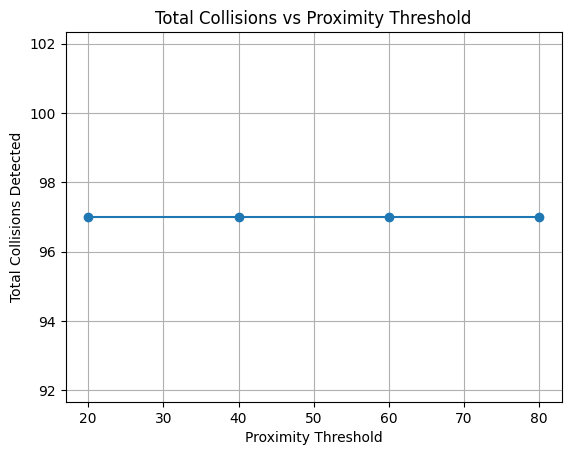

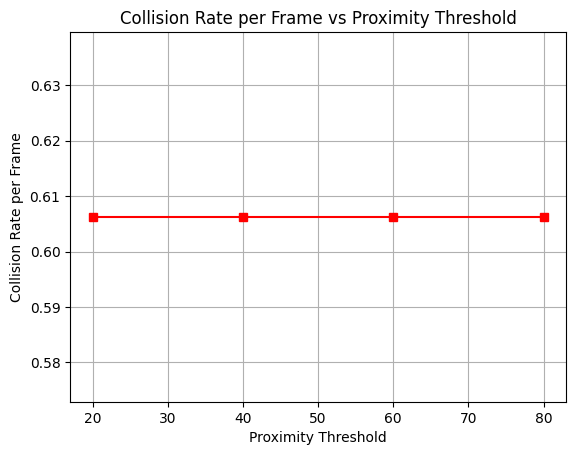

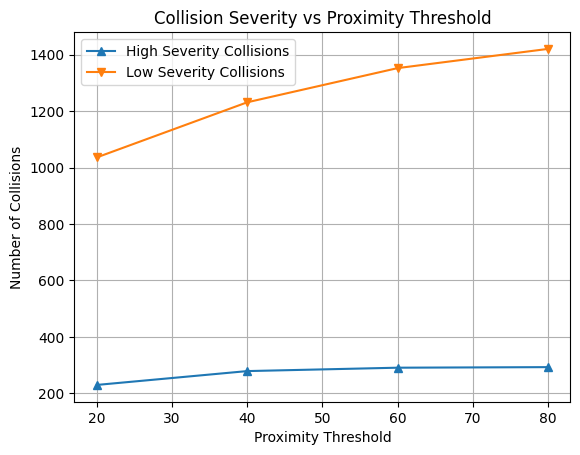

Threshold 20:
  Total Collisions: 97
  Frames: 160
  Collision per Frame: 0.6062
  High Severity: 230
  Low Severity: 1036

Threshold 40:
  Total Collisions: 97
  Frames: 160
  Collision per Frame: 0.6062
  High Severity: 279
  Low Severity: 1231

Threshold 60:
  Total Collisions: 97
  Frames: 160
  Collision per Frame: 0.6062
  High Severity: 291
  Low Severity: 1352

Threshold 80:
  Total Collisions: 97
  Frames: 160
  Collision per Frame: 0.6062
  High Severity: 293
  Low Severity: 1420



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define predict_collision function ---
def predict_collision(pos1, vel1, pos2, vel2, frames_ahead=10, proximity_threshold=60):
    future_positions1 = [pos1 + vel1 * t for t in range(frames_ahead)]
    future_positions2 = [pos2 + vel2 * t for t in range(frames_ahead)]

    min_distance = float('inf')
    for p1, p2 in zip(future_positions1, future_positions2):
        distance = np.linalg.norm(np.array(p1) - np.array(p2))
        min_distance = min(min_distance, distance)

    return min_distance < proximity_threshold

# --- Step 2: Define detect_and_track_players function with velocity calculation ---
def detect_and_track_players(frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=60):
    results = model.predict(source=frame, conf=0.5, save=False, device=0)
    detections = []
    player_velocities = {}
    collision_pairs = []
    collision_ids = set()  # New: to keep track of colliding players

    # Detection step
    for r in results:
        if len(r.boxes) > 0:
            for box in r.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                detections.append([[x1, y1, x2 - x1, y2 - y1], conf, cls])

    # Tracking step
    tracks = deep_sort.update_tracks(detections, frame=frame)
    tracked_players = []

    with open(output_tracking_results, "a") as f:
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = map(int, track.to_ltrb())

            if track_id not in player_positions:
                player_positions[track_id] = []

            center = np.array([(l + r) / 2, (t + b) / 2])
            player_positions[track_id].append((frame_idx, center[0], center[1]))
            tracked_players.append(([l, t, r, b, 1.0], track_id))

            f.write(f"{frame_idx},{track_id},{l},{t},{r-l},{b-t},1,-1,-1,-1\n")

    # Compute velocities
    for track_id, positions in player_positions.items():
        if len(positions) >= 2:
            (frame_prev, x_prev, y_prev) = positions[-2]
            (frame_now, x_now, y_now) = positions[-1]

            dt = frame_now - frame_prev
            if dt > 0:
                velocity = np.array([(x_now - x_prev) / dt, (y_now - y_prev) / dt])
            else:
                velocity = np.array([0, 0])
        else:
            velocity = np.array([0, 0])

        player_velocities[track_id] = velocity

    # Collision detection
    severity_counts = {"high": 0, "low": 0}

    for i in range(len(tracked_players)):
        for j in range(i + 1, len(tracked_players)):
            (x1, y1, x2, y2, _), id1 = tracked_players[i]
            (x3, y3, x4, y4, _), id2 = tracked_players[j]

            center1 = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
            center2 = np.array([(x3 + x4) / 2, (y3 + y4) / 2])
            vel1 = player_velocities.get(id1, np.array([0, 0]))
            vel2 = player_velocities.get(id2, np.array([0, 0]))

            intersection_x = max(0, min(x2, x4) - max(x1, x3))
            intersection_y = max(0, min(y2, y4) - max(y1, y3))
            intersection_area = intersection_x * intersection_y
            b1_area = (x2 - x1) * (y2 - y1)
            b2_area = (x4 - x3) * (y4 - y3)
            iou = 0
            if b1_area + b2_area - intersection_area > 0:
                iou = intersection_area / (b1_area + b2_area - intersection_area)

            collision_detected = (iou > 0.5 or predict_collision(center1, vel1, center2, vel2, proximity_threshold))

            if collision_detected:
                rel_velocity = np.linalg.norm(vel1 - vel2)
                severity = "HIGH" if rel_velocity > 8 else "LOW"

                severity_counts["high" if severity == "HIGH" else "low"] += 1
                collision_pairs.append((center1, center2, severity))

                # Mark these IDs as colliding
                collision_ids.add(id1)
                collision_ids.add(id2)

    # --- Draw bounding boxes and velocity arrows ---
    for (bbox, track_id) in tracked_players:
        x1, y1, x2, y2, _ = bbox
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

        # Flashing box color if in collision
        if track_id in collision_ids:
            color = (0, 0, 255)  # RED for players involved in collisions
            thickness = 4
        else:
            color = (0, 255, 0)  # GREEN normal
            thickness = 2

        # Draw bounding box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

        # Draw velocity arrow
        if track_id in player_velocities:
            velocity = player_velocities[track_id]
            speed = np.linalg.norm(velocity)
            if speed > 0.5:
                end_point = center + velocity * 10
                cv2.arrowedLine(frame, tuple(center.astype(int)), tuple(end_point.astype(int)), (255, 0, 0), 2)

    # --- Draw collision connection lines ---
    for center1, center2, severity in collision_pairs:
        color = (0, 0, 255) if severity == "HIGH" else (0, 165, 255)
        cv2.line(frame, tuple(center1.astype(int)), tuple(center2.astype(int)), color, 3)

        # Draw text at midpoint
        mid_point = ((center1 + center2) / 2).astype(int)
        text = f"Collision {severity}"
        cv2.putText(frame, text, (mid_point[0]-50, mid_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return tracked_players, len(collision_pairs) > 0, severity_counts

# --- Step 3: Process video across thresholds ---
video_path = "cand1.mp4"  # << replace with your real path
thresholds = [20, 40, 60, 80]

results_per_threshold = {t: {"total_collisions": 0, "high_severity": 0, "low_severity": 0, "frames": 0} for t in thresholds}

for threshold in thresholds:
    print(f"Processing video with proximity threshold {threshold}...")
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    player_positions = {}
    player_speeds = {}
    player_durations = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            print(f"[Warning] Failed to read frame for threshold {threshold} at frame {frame_idx}")
            break

        tracked_players, collision_detected, severity_counts = detect_and_track_players(
            frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=threshold
        )

        if collision_detected:
            results_per_threshold[threshold]["total_collisions"] += 1
            results_per_threshold[threshold]["high_severity"] += severity_counts["high"]
            results_per_threshold[threshold]["low_severity"] += severity_counts["low"]

        results_per_threshold[threshold]["frames"] += 1
        frame_idx += 1

    cap.release()

# --- Step 4: Safely calculate and plot results ---
thresholds_sorted = sorted(results_per_threshold.keys())
total_collisions = [results_per_threshold[t]["total_collisions"] for t in thresholds_sorted]
collision_per_frame = [
    results_per_threshold[t]["total_collisions"] / results_per_threshold[t]["frames"]
    if results_per_threshold[t]["frames"] > 0 else 0
    for t in thresholds_sorted
]
high_severity = [results_per_threshold[t]["high_severity"] for t in thresholds_sorted]
low_severity = [results_per_threshold[t]["low_severity"] for t in thresholds_sorted]

# Plot Total Collisions
plt.figure()
plt.plot(thresholds_sorted, total_collisions, marker='o')
plt.title("Total Collisions vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Total Collisions Detected")
plt.grid(True)
plt.show()

# Plot Collision Rate per Frame
plt.figure()
plt.plot(thresholds_sorted, collision_per_frame, marker='s', color='red')
plt.title("Collision Rate per Frame vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Collision Rate per Frame")
plt.grid(True)
plt.show()

# Plot Severity
plt.figure()
plt.plot(thresholds_sorted, high_severity, marker='^', label="High Severity Collisions")
plt.plot(thresholds_sorted, low_severity, marker='v', label="Low Severity Collisions")
plt.title("Collision Severity vs Proximity Threshold")
plt.xlabel("Proximity Threshold")
plt.ylabel("Number of Collisions")
plt.legend()
plt.grid(True)
plt.show()

# --- Step 5: Print results ---
for threshold, data in results_per_threshold.items():
    print(f"Threshold {threshold}:")
    print(f"  Total Collisions: {data['total_collisions']}")
    print(f"  Frames: {data['frames']}")
    if data['frames'] > 0:
        print(f"  Collision per Frame: {data['total_collisions'] / data['frames']:.4f}")
    else:
        print("  Collision per Frame: N/A (no frames)")
    print(f"  High Severity: {data['high_severity']}")
    print(f"  Low Severity: {data['low_severity']}")
    print()


In [ ]:
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# --- Step 6: Process the video for saving ---
output_video_path = "processed_cand2.mp4"
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

frame_idx = 0
player_positions = {}
player_speeds = {}
player_durations = {}

# For visualizations
speeds_over_time = {}  # {player_id: [(frame, speed)]}
all_positions_x = []
all_positions_y = []

total_high_severity = 0
total_low_severity = 0
total_collisions = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    tracked_players, collision_detected, severity_counts = detect_and_track_players(
        frame, frame_idx, player_positions, player_speeds, player_durations, proximity_threshold=60
    )

    total_collisions += collision_detected
    total_high_severity += severity_counts["high"]
    total_low_severity += severity_counts["low"]

 # Draw player velocities and collect speeds
    for bbox, track_id in tracked_players:
        x1, y1, x2, y2, _ = bbox
        center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

        if track_id in player_positions and len(player_positions[track_id]) >= 2:
            (f1, x_prev, y_prev) = player_positions[track_id][-2]
            (f2, x_now, y_now) = player_positions[track_id][-1]
            dt = f2 - f1

            if dt > 0:
                velocity = np.array([(x_now - x_prev) / dt, (y_now - y_prev) / dt])
                speed = np.linalg.norm(velocity)

                # Save speeds
                if track_id not in speeds_over_time:
                    speeds_over_time[track_id] = []
                speeds_over_time[track_id].append((frame_idx, speed))

                # Draw velocity arrow
                end_point = center + velocity * 10
                cv2.arrowedLine(frame, tuple(center.astype(int)), tuple(end_point.astype(int)), (255, 0, 0), 2)

                # Display speed
                cv2.putText(frame, f"{speed:.1f}", (int(center[0]), int(center[1])-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Save positions for heatmap
    for track_id, positions in player_positions.items():
        if positions:
            _, x, y = positions[-1]
            all_positions_x.append(x)
            all_positions_y.append(y)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"[INFO] Saved processed video to {output_video_path}")



0: 640x512 (no detections), 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.1ms
Speed: 3.7ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 12.4ms
Speed: 4.6ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 11 persons, 12.1ms
Speed: 3.5ms preprocess, 12.1ms inference, 1.5ms postprocess per ima